# Molecular Similarity Search
In this example we are performing a similarity retrieval of molecular formulae by generating molecular fingerprints using RDKit. With this fingerprints we use Milvus to perform a search for the most similar result to the target molecular formula.

## Data
We have already prepared a SMILE file containing 10,000 molecular formulae [test_1w.smi](./smiles-data) from [pubchem](ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF). The file is composed of two columns, SMILES and ID. Below is an example of the data: 

| SMILES | ID |
| --------------- | -------------- |
| [O-]C(=O)CC(C[N+](C)(C)C)OC(=O)C        | 1 |
| OC(=O)CC(C[N+](C)(C)C)OC(=O)C           | 2 |
| OC1C=CC=C(C1O)C(=O)O                    | 3 |
| CC(CN)O                                 | 4 |
| NCC(=O)COP(=O)(O)O                      | 5 |


## Requirements

Before running this notebook, you need to install [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) or [miniconda](https://docs.conda.io/en/latest/miniconda.html) locally. This is required due to [RDKit](https://www.rdkit.org/docs/Install.html) only being installable through conda. Once conda is setup, you need to active a conda enviroment running `Python 3.7`. It can be done quickly with the following command: `conda create -n mol_search python=3.7`. Once created, activate the enviroment with `conda activate mol_search`. Once the enviroment is activated you can run the notebook, in our case we are using jupyter, so this can be done running the command `jupyter lab` in this notebooks directory. 


| Packages |  Servers |
| --------------- | -------------- |
| pymilvus-orm        | Milvus-2.0.0   |
| pymysql           | MySQL          |
| numpy |
| rdkit |
We have included a requirements.txt file in order to easily satisfy the required packages.


## Up and Running
### Installing RDkit
Install RDKit with Conda.

In [1]:
!conda install -c rdkit rdkit -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/filiphaltmayer/opt/miniconda3/envs/test

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bzip2-1.0.8                |       h1de35cc_0          75 KB
    cairo-1.16.0               |       h8023c5d_1         911 KB
    fontconfig-2.13.1          |       ha9ee91d_0         211 KB
    freetype-2.10.4            |       ha233b18_0         564 KB
    gettext-0.21.0             |       h7535e17_0         2.6 MB
    glib-2.68.1                |       hdf23fa2_0         2.7 MB
    icu-58.2                   |       h0a44026_3        10.1

### Installing Packages
Install the required python packages with `requirements-v2.txt`.

In [2]:
! pip install -r requirements.txt

  Using cached pymilvus-1.1.0-py3-none-any.whl (56 kB)
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
     |████████████████████████████████| 43 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 959 kB 24.1 MB/s eta 0:00:01


### Starting Milvus
Start Docker container without mapping the files, if you want to map the paths to the local files to the container, you can refer to [Install and Start Milvus](https://milvus.io/docs/v1.1.0/milvus_docker-cpu.md).

In [51]:
! docker-compose up -d

Creating network "milvus" with the default driver
Creating milvus-minio ... 
Creating milvus-etcd  ... 
ting milvus-minio ... doneCreating milvus-standalone ... 
ting milvus-standalone ... done

### Starting MySQL
We are using MySQL as a metadata storage service. Code can easily be modified to use a python dictionary, but that usually does not work in any use case outside of quick examples. We need a metadata storage service in order to be able to be able to map between embeddings and their corresponding molecular formulae. 

In [52]:
! docker run --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=123456 -d mysql:5.7

f5ab1dd47e4134385aaa6c10bd8a47b121187d8301629dca314b53f065db591c


### Confirm Running Servers

In [59]:
! docker ps

CONTAINER ID   IMAGE                                         COMMAND                  CREATED          STATUS                             PORTS                                                  NAMES
f5ab1dd47e41   mysql:5.7                                     "docker-entrypoint.s…"   23 seconds ago   Up 21 seconds                      0.0.0.0:3306->3306/tcp, :::3306->3306/tcp, 33060/tcp   mysql
dbab8c9596ae   milvusdb/milvus:v2.0.0-rc5-20210830-1c88c8b   "/tini -- milvus run…"   25 seconds ago   Up 23 seconds                      0.0.0.0:19530->19530/tcp, :::19530->19530/tcp          milvus-standalone
312ec1d7cf17   minio/minio:RELEASE.2020-12-03T00-03-10Z      "/usr/bin/docker-ent…"   26 seconds ago   Up 24 seconds (health: starting)   9000/tcp                                               milvus-minio
516ed75f7e42   quay.io/coreos/etcd:v3.5.0                    "etcd -advertise-cli…"   26 seconds ago   Up 24 seconds                      2379-2380/tcp                                  

## Code Overview
### Connecting to Servers
After preparing the conda environment (installing RDKit, etc.) and successfully starting Milvus and MySQL, we will begin by connecting to the servers. In this case the docker containers are running on localhost and the ports are the default ports.

> If there was a problem downloading the required packages and no Milvus module can be found, please run the requirments.txt install again in a terminal that has the conda enviroment activated.

In [60]:
# Connecting to servers

import pymysql
import time

import pymilvus.orm.pymilvus_orm as orm
from pymilvus import DataType


time.sleep(1)

milv = orm.connections.connect("default", host = "localhost", port= 19530)
conn = pymysql.connect(host='localhost', user='root', port=3306, password='123456', db='mysql', local_infile=True)
cursor = conn.cursor()

### Building Collection and Setting Indexing

We first begin by declaring some variables, such as the dimension of the vector, the name of the collection/table, the path of the SMILES file and the SMILES molecule we will be searching.

In [61]:
VECTOR_DIMENSION = 512
collection_name = 'mol_search'
file_path = './smiles-data/test_1w.smi'
target_smiles = 'Cc1ccc(cc1)S(=O)(=O)N'
distance_type = 'JACCARD'
index_type = 'BIN_IVF_FLAT'
nlist = 512
nprobe = 16
topk = 3

For this example we are using the Jaccard distance in order to calculate similarity between vectors. 

In [62]:
#Create collection
def create_collection(name, milv):
    
    id_field = orm.schema.FieldSchema(name="id_field", dtype=DataType.INT64, description="milv_id")
   
    vector_field = orm.schema.FieldSchema(name="mol_vectors", dtype=DataType.BINARY_VECTOR, dim=VECTOR_DIMENSION, description="vectors")

    schema = orm.schema.CollectionSchema(fields =[id_field, vector_field], primary_field="id_field", auto_id=False, description="collection of mols data")
    
    collection = orm.collection.Collection(name=collection_name, schema=schema)
    print("collection created:", collection_name)

if orm.utility.has_collection(collection_name) == True:
        c = orm.collection.Collection(collection_name)
        c.drop()
        print("collection dropped:", collection_name)

cursor.execute('DROP TABLE IF EXISTS ' + collection_name)
conn.commit()


time.sleep(.1)

create_collection(collection_name, milv)

collection created: mol_search


For the index we are using the binary_ivf_flat index. We can set the index before inserting data so that it indexes concurrently.

In [63]:
def create_index(name, field_name, milv):
    index_param = {
        "metric_type": distance_type,
        "index_type": index_type,
        "params": {"nlist": nlist}
    }
    c = orm.collection.Collection(collection_name)
    index = orm.index.Index(c, field_name, index_param)
    print("Created index: {}".format(index_param))

create_index(collection_name, "mol_vectors", milv)


Created index: {'metric_type': 'JACCARD', 'index_type': 'BIN_IVF_FLAT', 'params': {'nlist': 512}}


### Processing and Inserting Data into Milvus
We can use RDKit to generate Morgan fingerprints, which defines a radius from a specific atom and calculates the number of chemical structures within the range of the radius to generate a chemical fingerprint. 

In [64]:
#Process SMILES

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

def smiles_to_vec(smiles):
    mols = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mols, 2, VECTOR_DIMENSION)
    hex_fp = DataStructs.BitVectToFPSText(fp)
    vec = bytes.fromhex(hex_fp)
    return vec

def get_vectors(file_path):
    ids = []
    vectors = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip().split()
            smiles = line[0]
            num = int(line[1])
            vec = smiles_to_vec(smiles)
            vectors.append(vec)
            ids.append(num)
    return vectors, ids

Then we can then read the SMILES file and batch insert it into Milvus.

In [65]:
# Batch insert

vectors, ids = get_vectors(file_path)
c = orm.collection.Collection(collection_name)
c.insert([ids, vectors])


RDKit WARNING: [15:03:27] WARNING: not removing hydrogen atom without neighbors


(insert count: 10000, delete count: 0, upsert count: 0, timestamp: 427457304429854721)

### Loading Mapping into MySQL
After recieving the IDs from milvus we must save the mapping between the vector and the SMILES molecule. 
We do this buy saving the (ID, SMILES) pair in a table.

In [66]:
# Create the table in MySQL

def create_table_mysql(conn, cursor, table_name):
    sql = "create table if not exists " + table_name + "(smiles varchar(256), ids bigint);"
    try:
        cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

# Load the local file to MySQL

def load_data_mysql(conn, cursor, table_name, file_path):
    sql = "load data local infile '" + file_path + "' into table " + table_name + ";"
    try:
        cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

In [67]:
create_table_mysql(conn, cursor, collection_name)
load_data_mysql(conn, cursor, collection_name, file_path)

### Searching
With the data loaded in Milvus and the mapping loaded into MySQL, we can now perform the search. To begin, we must first transform the SMILES molecule into a molecular fingerprint. Then, with this fingerprint we can search the database, which gives us the closest IDs with their distances.


In [68]:
# Perform search
def search(name, vector_field, smiles):
    search_vectors = [smiles_to_vec(smiles)]
    nq = len(search_vectors)
    search_params = {"metric_type": distance_type, "params": {"nprobe": nprobe}}
    
    c = orm.collection.Collection(collection_name)
    
    results = c.search(search_vectors, vector_field, search_params, topk)
    
    re_ids = [x.id for x in results[0]]
    re_distance = [x.distance for x in results[0]]
    return re_ids, re_distance

With the IDs we can then search the MySQL table to find the corresponding SMILES molecules.

In [69]:
# Get SMILES results
def search_by_milvus_id(conn, cursor, collection_name, ids):
    str_ids = str(ids).replace('[','').replace(']','')
    sql = "select smiles from " + collection_name + " where ids in (" + str_ids + ") order by field (ids, " + str_ids + ");"
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        results = [res[0] for res in results]
        return results
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

In [70]:
# Reload collection: for now safer to release and load before search
def reload_collection():
    c = orm.collection.Collection(collection_name)
    c.release()
    c.load()

In [71]:
reload_collection()

re_ids, re_distance = search(collection_name, "mol_vectors", target_smiles)
re_smiles = search_by_milvus_id(conn, cursor, collection_name, re_ids)
print(re_smiles)

['Cc1ccc(cc1)S(=O)(=O)N', 'Cc1ccc(cc1)S(=O)(=O)Cl', 'Nc1ccc(cc1)S(=O)(=O)N']


target-smiles: Cc1ccc(cc1)S(=O)(=O)N


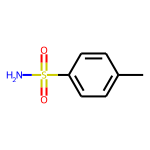

results: 
Cc1ccc(cc1)S(=O)(=O)N 	ids: 6269 	distance: 0.0


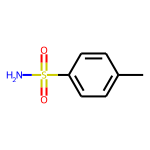

Cc1ccc(cc1)S(=O)(=O)Cl 	ids: 7397 	distance: 0.3636363744735718


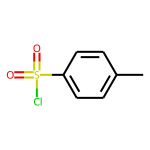

Nc1ccc(cc1)S(=O)(=O)N 	ids: 5333 	distance: 0.40909090638160706


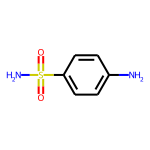

In [72]:
#Display Results

from rdkit.Chem import Draw

def draw_smiles(smiles):
    mols = Chem.MolFromSmiles(smiles)
    img = Draw.MolsToGridImage([mols], molsPerRow=1, subImgSize=(150, 150))
    return img

img = draw_smiles(target_smiles)
print("target-smiles:", target_smiles)
display(img)
print("results: ")

for s, i, d in zip(re_smiles,re_ids, re_distance):
    print(s, "\tids:", i, "\tdistance:", d)
    display(draw_smiles(s))

## Conclusion
This notebook shows how to search for similar molecules. We can also search the superstructure and substructure with the different [METRICS](https://milvus.io/docs/v1.1.0/metric.md#floating) when searching in Milvus.

We have also built a [demo system](https://zilliz.com/milvus-demos), and also have an open source projects on substructure and superstructure search in [MolSearch](https://github.com/zilliztech/MolSearch). 

In [73]:
! docker-compose down

Stopping milvus-standalone ... 
Stopping milvus-minio      ... 
Stopping milvus-etcd       ... 
ping milvus-minio      ... doneRemoving milvus-standalone ... 
Removing milvus-minio      ... 
Removing milvus-etcd       ... 
Removing network milvus... done


In [74]:
!docker stop mysql
!docker rm  mysql


mysql
mysql
